In [ ]:
# Following script combines the annotation data with the time series data
path = r'C:\Users\Grover\Documents\GitHub\EZLabel\true_annotations'
dict_path = r'Z:\mfk\basty-projects\tmp_results\predictions\ProboscisPumping\bouts_dict.pkl'

import pandas as pd
import os
import glob


def process_row(row, dictionary, N):
    df_dict = dictionary[row['name']]
    df_dict_filtered = df_dict.drop(['start_index', 'stop_index', 'region'], axis=1)

    trial_id = int(row['trial_id'])
    peak_index = row['peak_index']

    # New dictionary to store sliced data with column names
    sliced_data_dict = {}

    for col in df_dict_filtered.columns:
        if peak_index-N >= 0 and peak_index+N <= len(df_dict_filtered.loc[trial_id, col]):
            start = max(0, peak_index - N)
            end = min(len(df_dict_filtered.loc[trial_id, col]), peak_index + N)
            sliced_data_dict[col] = df_dict_filtered.loc[trial_id, col][start:end]

    return sliced_data_dict


In [ ]:

pkl_files = glob.glob(os.path.join(path, '*.pkl'))
ts_dict = pd.read_pickle(dict_path)

df_list = []  # A list to store each DataFrame


for file in pkl_files:
    data = pd.read_pickle(file)
    df = pd.DataFrame(data)
    df['name'] = os.path.splitext(os.path.basename(file))[0]
    df_list.append(df)  # Append the DataFrame to the list

# Concatenate all the DataFrames in the list into a single DataFrame
annotations = pd.concat(df_list, ignore_index=True)

# Rename the columns to make it more intuitive
annotations.rename(columns = {'index':'peak_index','column':'trial_id'},inplace=True)

In [ ]:
annotations

In [ ]:
annotations

In [ ]:
# Create an empty DataFrame to store all the processed rows
processed_data_df = pd.DataFrame()

# Initialize a counter for slice
slice_counter = 0

# Loop through each row in annotations
for i, row in annotations.iterrows():
    processed_row = process_row(row, ts_dict, 30)

    # Create a DataFrame for this row
    row_df = pd.DataFrame(processed_row)

    # Add 'slice_id' to the DataFrame
    row_df['slice_id'] = slice_counter

    # Set a multi-index using 'name', 'slice_id' and the existing index of row_df
    row_df.index = pd.MultiIndex.from_tuples([(row['name'], slice_counter, i) for i in row_df.index],
                                             names=['name', 'slice_id', 'time'])

    # Append it to processed_data_df
    processed_data_df = pd.concat([processed_data_df, row_df])

    # Increment the slice_counter
    slice_counter += 1


In [ ]:
import numpy as np
# Create a dictionary where key is (name, slice_id) and value is the sub-DataFrame
df_dict = dict(tuple(processed_data_df.groupby(level=['name', 'slice_id'])))

# Initialize an empty list to store each 2D array
array_list = []

# Loop over the dictionary
for key in df_dict:
    # Convert each DataFrame to a 2D numpy array and append to list
    array_list.append(df_dict[key].values)

# Convert list of arrays to a 3D numpy array
np_array = np.stack(array_list)


In [ ]:
output_path = r'C:\Users\Grover\Documents\GitHub\EZLabel'

processed_data_df.to_pickle(os.path.join(output_path,'false_peak_annotations.pkl'))

In [ ]:
np.save(os.path.join(output_path,'false_peak_annotations.npy'),np_array)

In [ ]:
output_path = r'C:\Users\Grover\Documents\GitHub\EZLabel\true_annotations\output'
annotations.to_pickle(os.path.join(output_path,'true_annotations.pkl'))

In [ ]:
import pandas as pd
import os

# Load annotations and experimental info: 
path = r'C:\Users\Grover\Documents\GitHub\EZLabel\true_annotations'
annotations = pd.read_pickle(os.path.join(path,'output','true_annotations.pkl'))
expt_info_df_path = r'Z:\mfk\basty-projects\expt_info_df.pkl'
expt_info_df = pd.read_pickle(expt_info_df_path)

# Fetch all .mp4 files from the directory
directory = r'Y:\DeepSleepPaperData\Annotated\PredictedVideos\Pumping'
file_names = [f for f in os.listdir(directory) if f.endswith('.mp4')]

# Process each filename
data = []

for file in file_names:
    parts = file.split("_")

    index_position = parts.index('index')
    name = "_".join(parts[:index_position])
    trial_id = int(parts[index_position + 1])
    start = int(parts[parts.index('start') + 1])

    data.append([name, trial_id, start])

# Construct the DataFrame
df = pd.DataFrame(data, columns=["name", "trial_id", "start"])

annotations['trial_id'] = annotations['trial_id'].astype('int64')
df['trial_id'] = df['trial_id'].astype('int64')
merged_df = annotations.merge(df[['name', 'trial_id', 'start']], on=['name', 'trial_id'], how='left')

merged_df['pump_pos'] = merged_df['peak_index'] + merged_df['start']

In [ ]:
merged_df.to_csv(os.path.join(path,"all_true_annotations.csv"))

In [ ]:
name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))

df = merged_df

# Split df into two based on SD value
df_sd_true = df[df['name'].map(name_to_sd)]
df_sd_false = df[~df['name'].map(name_to_sd)]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# Helper function to plot given a subset of df
def plot_data(subset_df, color, sd, sex):
    fig, ax = plt.subplots(figsize=(15, len(subset_df['name'].unique()) / 4))
    unique_names = subset_df['name'].unique()

    for idx, name in enumerate(unique_names):
        sub_subset_df = subset_df[subset_df['name'] == name]
        for _, row in sub_subset_df.iterrows():
            pump_pos = row['pump_pos']
            ax.barh(idx, 60, left=pump_pos - 30, color=color, edgecolor='none')

    fly_labels = [f"Fly{i+1}" for i in range(len(unique_names))]
    ax.set_yticks(range(len(unique_names)))
    ax.set_yticklabels(fly_labels)

    ZT_ticks, ZT_ticklabels = generate_tick_data(30, sd=sd)
    ax.set_xticks(ZT_ticks)
    ax.set_xticklabels(ZT_ticklabels)

    # Set x-axis limits to the beginning and end of the x-ticks
    ax.set_xlim(ZT_ticks[0], ZT_ticks[-1])

    title = f'SD_True_{sex}' if sd else f'SD_False_{sex}'
    ax.set_title(title)

    plt.tight_layout()
    plt.savefig(f'Pump_Positions_{title}.pdf')
    plt.show()


# Function to plot data for SD = True
def plot_sd_true():
    df_sd_true = df[df['name'].map(name_to_sd)]
    plot_data(df_sd_true, '#377eb8', sd=True)


# Function to plot data for SD = False
def plot_sd_false():
    df_sd_false = df[~df['name'].map(name_to_sd)]
    plot_data(df_sd_false, '#d62728', sd=False)
    
def plot_sub_data(df, expt_info_df, sd, sex,plot_it):
    # Create mappings from expt_info_df
    name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
    name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))
    
    # Filter based on provided sd and sex values
    sub_df = df[(df['name'].map(name_to_sd) == sd) & (df['name'].map(name_to_sex) == sex)]
    
    if plot_it:
        plot_data(sub_df, '#d62728', sd=sd,sex=sex)
    
    return sub_df,sd,sex
    
def generate_tick_data(FPS=30, sd=False):

    if sd == False:
        xticks = np.arange(
            start=0, stop=FPS * 60 * 60 * 16 + 1, step=FPS * 60 * 60 * 2
        )
        ZT_ticks = xticks
        ZT_ticklabels = [
            "ZT" + str((tick + 10) % 24) for tick in range(0, len(xticks) * 2, 2)
        ]
    else:
        xticks = np.arange(
            start=0, stop=FPS * 60 * 60 * 6 + 1, step=FPS * 60 * 60 * 1
        )
        ZT_ticks = xticks
        ZT_ticklabels = [
            "ZT" + str(tick) for tick in range(0, len(xticks) * 1, 1)
        ]

    return ZT_ticks, ZT_ticklabels


In [ ]:
plot_sub_data(df,expt_info_df,sd=False,sex='F')

In [ ]:
import pandas as pd

def plot_bin_data(sub_df,sd,sex):
    plot_Df = sub_df
    # Convert pump_pos to minutes
    plot_Df['pump_pos_minutes'] = plot_Df['pump_pos'] / (30 * 60)
    
    # Define bin edges for 60-minute intervals
    max_minutes = plot_Df['pump_pos_minutes'].max()
    bins = list(range(0, int(max_minutes) + 61, 60))
    
    # For each unique 'name', bin the data and count values in each bin
    binned_data = {}
    for name, group in plot_Df.groupby('name'):
        binned_data[name] = pd.cut(group['pump_pos_minutes'], bins=bins).value_counts()
    
    # Convert the binned_data dictionary to a DataFrame
    binned_df = pd.DataFrame(binned_data).T
    binned_df = binned_df.fillna(0).astype(int)  # Replace NaN values with zeros and convert to integer type
    
    # Calculate the average for each bin across all "names"
    melted_df = binned_df.melt(var_name='Time Bin', value_name='Average Count')
    
    import seaborn as sns

    # Create the boxplot using seaborn
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=melted_df, x='Time Bin', y='Average Count', showfliers=False, color="skyblue", width=0.5, notch=False, boxprops=dict(edgecolor='none'))
  # Adjusted box width and color
    
    # Calculate the median values for each time bin and plot them
    medians = melted_df.groupby('Time Bin')['Average Count'].median()
    plt.plot(range(len(medians)), medians, color='black', linestyle='-', marker='o')
    
    # Set the x-tick labels to your ZT values
    if ~sd:
        ZT_labels = [f"ZT{((i + 10) % 24)}" for i in range(len(medians))]
        plt.xticks(ticks=range(len(ZT_labels)), labels=ZT_labels, rotation=45)
    else:
        ZT_labels = [f"ZT{((i))}" for i in range(len(medians))]
        plt.xticks(ticks=range(len(ZT_labels)), labels=ZT_labels, rotation=45)
        
    
    # Set y-label
    plt.ylabel("Pump per Hour")

    
    title = f"Avg_Binned_SD_{sd}_sex{sex}"
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'{title}.pdf')
    plt.show()

In [ ]:
sub,sd,sex = plot_sub_data(df,expt_info_df,sd=True,sex='F',plot_it=False)

In [ ]:
plot_bin_data(sub,sd,sex)

In [ ]:
# Calculate Bouts
def calculate_bouts(target_df, target_threshold):
    # Re-initialize the 'bouts' column with default value 0
    target_df['bouts'] = 0
    
    # Loop through each unique 'name' to identify bouts based on 'pump_pos'
    for name in target_df['name'].unique():
        # Filter the DataFrame for the current 'name'
        subset_df = target_df[target_df['name'] == name].sort_values(by='pump_pos')
        
        # Calculate the differences between consecutive 'pump_pos'
        pump_diffs = subset_df['pump_pos'].diff().fillna(0)
        
        # Initialize a variable to keep track of the current bout number
        current_bout = 0
        
        # Initialize a variable to keep track of the last pump position in the current bout
        last_pump_in_bout = -1
        
        # Loop through the DataFrame to identify bouts
        for idx, pump_diff in pump_diffs.items():
            if pump_diff > target_threshold:
                # If the difference between the current and last pump position is greater than the threshold, start a new bout
                current_bout += 1
                last_pump_in_bout = target_df.loc[idx, 'pump_pos']
            elif last_pump_in_bout != -1 and (target_df.loc[idx, 'pump_pos'] - last_pump_in_bout) > target_threshold:
                # If the difference between the current pump position and the last pump position in the current bout is greater than the threshold, start a new bout
                current_bout += 1
                last_pump_in_bout = target_df.loc[idx, 'pump_pos']
            else:
                # Otherwise, the current pump position is part of the current bout
                last_pump_in_bout = target_df.loc[idx, 'pump_pos']
            
            # Label the current bout number in the 'bouts' column
            target_df.loc[idx, 'bouts'] = current_bout
            
    return target_df



In [ ]:
# Update the threshold for identifying bouts to 210
threshold = 330
bout_df = merged_df.copy()

In [ ]:
df = calculate_bouts(bout_df,threshold)

In [ ]:
sorted_df = df.sort_values(by=['name', 'pump_pos'])

In [ ]:
print(sorted_df.head())

In [ ]:
import matplotlib.pyplot as plt
def plot_bout_data(subset_df, color, sd=False, sex="unknown"):
    fig, ax = plt.subplots(figsize=(15, len(subset_df['name'].unique()) / 4))
    unique_names = subset_df['name'].unique()

    for idx, name in enumerate(unique_names):
        sub_subset_df = subset_df[subset_df['name'] == name]
        
        for bout, bout_df in sub_subset_df.groupby('bouts'):
            min_pump_pos = bout_df['pump_pos'].min()
            ax.barh(idx, 60, left=min_pump_pos - 30, color=color, edgecolor='none')

    fly_labels = [f"Fly{i+1}" for i in range(len(unique_names))]
    ax.set_yticks(range(len(unique_names)))
    ax.set_yticklabels(fly_labels)

    ZT_ticks, ZT_ticklabels = generate_tick_data(30, sd=sd)
    ax.set_xticks(ZT_ticks)
    ax.set_xticklabels(ZT_ticklabels)

    # Set x-axis limits to the beginning and end of the x-ticks
    ax.set_xlim(ZT_ticks[0], ZT_ticks[-1])

    title = f'SD_True_{sex}' if sd else f'SD_False_{sex}'
    ax.set_title(title)

    plt.tight_layout()
    plt.savefig(f'Pump_Positions_bouts_{title}.pdf')
    plt.show()

In [ ]:
def plot_bout_sub_data(df, expt_info_df, sd, sex,plot_it):
    # Create mappings from expt_info_df
    name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
    name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))
    
    # Filter based on provided sd and sex values
    sub_df = df[(df['name'].map(name_to_sd) == sd) & (df['name'].map(name_to_sex) == sex)]
    
    if plot_it:
        plot_bout_data(sub_df, '#d62728', sd=sd,sex=sex)
    

In [ ]:
plot_bout_sub_data(sorted_df,expt_info_df,True,'M',True)

In [ ]:
print(sorted_df.head())

In [ ]:
grouped = sorted_df.groupby(['name','bouts']).size().reset_index(name = 'counts')

In [ ]:
# Possible values for sd and sex
sd_values = [False, True]
sex_values = ['M', 'F']
name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))

grouped_dict = {}

# Loop through each combination of sd and sex to filter and store the DataFrame
for sd in sd_values:
    for sex in sex_values:
        sub_df = grouped[(grouped['name'].map(name_to_sd) == sd) & (grouped['name'].map(name_to_sex) == sex)]
        key = f"sd_{sd}_sex_{sex}"
        grouped_dict[key] = sub_df

In [ ]:
grouped_dict.keys()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_single_histogram_with_average(grouped_df, title):
    plt.figure(figsize=(12, 8))
    
    all_hist_data = []
    
    # Determine common bin edges based on the entire data range
    data_min = grouped_df['counts'].min()
    data_max = grouped_df['counts'].max()
    bin_edges = np.linspace(data_min, data_max, 21)
    
    for name, group in grouped_df.groupby('name'):
        hist_data, _ = np.histogram(group['counts'], bins=bin_edges, density=True)
        all_hist_data.append(hist_data)
        
        # Using plt.plot with specified linewidth
        plt.plot(bin_edges[:-1], hist_data, label=f"{name}", alpha=0.5, color='lightblue', linewidth=1)
    
    # Compute the average histogram
    avg_hist = np.mean(all_hist_data, axis=0)
    
    # Using step function for connected bars
    plt.step(bin_edges[:-1], avg_hist, where='mid', color='black', label='Average', linewidth=2, alpha=0.7)
    
    plt.title(title)
    plt.xlabel('Counts')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [ ]:
print(grouped_dict['sd_False_sex_M'].head())

In [ ]:
plot_single_histogram_with_average(grouped_dict['sd_True_sex_F'],'title')

In [ ]:
grouped_dict['sd_False_sex_M']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

def plot_grouped_boxplots(grouped_dict, filename=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    # Plot for sd=False
    sns.boxplot(data=[grouped_dict[key]['counts'] for key in grouped_dict if 'sd_False' in key], 
                ax=axes[0], showfliers=False)
    axes[0].set_xticklabels([key for key in grouped_dict if 'sd_False' in key])
    axes[0].set_title("sd=False")
    axes[0].set_ylabel("Counts")
    
    # Plot for sd=True
    sns.boxplot(data=[grouped_dict[key]['counts'] for key in grouped_dict if 'sd_True' in key], 
                ax=axes[1], showfliers=False)
    axes[1].set_xticklabels([key for key in grouped_dict if 'sd_True' in key])
    axes[1].set_title("sd=True")
    axes[1].set_ylabel("Counts")

    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    else:
        plt.show()

# Usage:
plot_grouped_boxplots(grouped_dict, filename="bout_box_plot.pdf")




In [ ]:
suber_df.sort_values(by=['counts'],ascending=False)

In [ ]:
sorted_df[sorted_df['name'] == 'Fly06272022_5d_A']

In [ ]:
grouped

In [ ]:
rep_trace_path = r'Z:\mfk\basty-projects\bouts_to_csv\Fly06272022_5d_A.csv'
rep_trace = pd.read_csv(rep_trace_path)
# Define your start, stop, and step values for the ticks
start = 500
stop = 5600
step = 10*30

# Generate the tick positions and labels
tick_positions = np.arange(start, stop, step)
tick_labels = np.arange(0, len(tick_positions)*10, 10)

# Plot the data
plt.plot(rep_trace['65'][start:stop])
plt.ylabel('Euclidian Distance (px)')
plt.xlabel('Time (s)')
# Set the x-axis ticks and labels
plt.xticks(tick_positions, tick_labels)
plt.savefig('example_trace_49_pumps_trial_65_fly06272022_5d_A.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Calculate the count of elements in a bout for each unique name and bout
sorted_df['bout_count'] = sorted_df.groupby(['name', 'bouts'])['peak_index'].transform('count')

# Calculate the pump_pos corresponding to the first element (minimum) for a bout
sorted_df['min_pump_pos'] = sorted_df.groupby(['name', 'bouts'])['pump_pos'].transform('min')


In [ ]:
distinct_df = sorted_df[['name', 'bout_count','min_pump_pos']].drop_duplicates().reset_index(drop=True)

In [ ]:
sns.scatterplot(x='min_pump_pos', y='bout_count', data=sub_distinct)
plt.title('Scatterplot of bout_count vs. min_pump_pos')
plt.show()

In [169]:
sub_distinct =  distinct_df[(distinct_df['name'].map(name_to_sd) == True) ]

In [ ]:
unique_names = sub_distinct['name'].unique()

for name in unique_names:
    subset = sub_distinct[sub_distinct['name'] == name]
    sns.scatterplot(x='min_pump_pos', y='bout_count', data=subset)
    plt.title(f'Scatterplot for {name}')
    plt.show()

C:\Users\Grover\anaconda3\envs\flysleepcl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


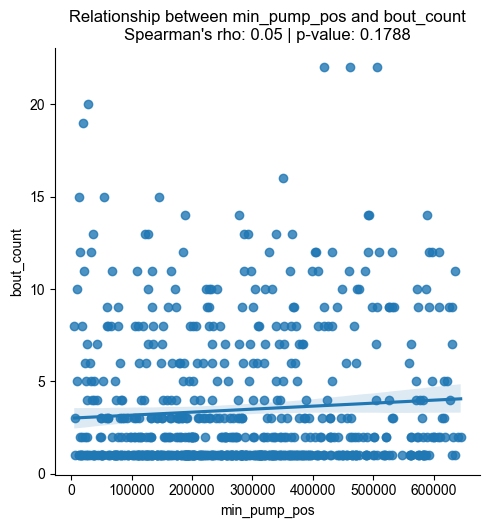

In [172]:
from scipy.stats import spearmanr
sns.lmplot(x='min_pump_pos',y='bout_count',data = sub_distinct)
rho, p = spearmanr(sub_distinct['min_pump_pos'], sub_distinct['bout_count'])
plt.title(f"Relationship between min_pump_pos and bout_count\nSpearman's rho: {rho:.2f} | p-value: {p:.4f}")
plt.show()

In [175]:
print(sorted_df.head())

    peak_index        value  trial_id            name  start  pump_pos  bouts  \
0          534  1014.361120         0  Fly05182022_5d   2349      2883      0   
1          694  1017.733769         0  Fly05182022_5d   2349      3043      0   
2          903  1027.228163         0  Fly05182022_5d   2349      3252      0   
3         1207  1021.721591         0  Fly05182022_5d   2349      3556      0   
84        1439   916.637105         0  Fly05182022_5d   2349      3788      0   

    bout_count  min_pump_pos  
0            6          2883  
1            6          2883  
2            6          2883  
3            6          2883  
84           6          2883  


In [187]:
threshold = 3

# Filtering based on bout_count
filtered_df = sorted_df[sorted_df['bout_count'] >= threshold]

# Calculate differences between consecutive peak_index values for each group
filtered_df['peak_diff'] = filtered_df.groupby(['name', 'bouts'])['pump_pos'].diff().fillna(0)


C:\Users\Grover\AppData\Local\Temp\ipykernel_39200\2093103244.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['peak_diff'] = filtered_df.groupby(['name', 'bouts'])['pump_pos'].diff().fillna(0)


In [188]:
filtered_df = filtered_df[filtered_df['peak_diff'] != 0]

In [192]:
filtered_df.peak_diff.mean()

110.65689102564103

C:\Users\Grover\anaconda3\envs\flysleepcl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


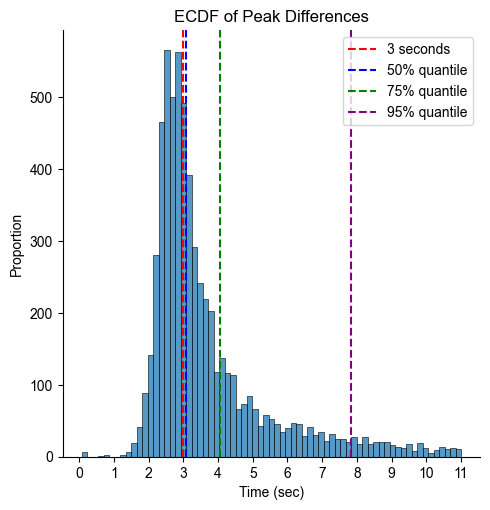

In [206]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# PLOT ECDF FOR ALL THE DATA

# Create displot with ECDF
sns.displot(x=filtered_df['peak_diff'], kind='hist')

# Adjusting x-ticks to 1-second increments (30 data points = 1 second)
max_value = filtered_df['peak_diff'].max()
xticks = np.arange(0, max_value + 30, 30)
xticklabels = [str(int(x/30)) for x in xticks]

plt.xticks(xticks, xticklabels)
plt.xlabel('Time (sec)')
plt.ylabel('Proportion')
plt.title('ECDF of Peak Differences')

# Add a dashed vertical line at the 3-second mark (90 data points)
plt.axvline(x=90, linestyle='--', color='red', label='3 seconds')

# Calculate and plot the 50%, 75%, and 95% quantiles
for quantile, color in zip([0.50, 0.75, 0.95], ['blue', 'green', 'purple']):
    value_at_quantile = np.percentile(filtered_df['peak_diff'], quantile * 100)
    plt.axvline(x=value_at_quantile, linestyle='--', color=color, label=f'{int(quantile * 100)}% quantile')

plt.legend()
plt.show()



In [ ]:
# PLOT ECDF with different groups in the same plot.



In [195]:
from sklearn.mixture import GaussianMixture
import numpy as np

data = filtered_df['peak_diff'].values.reshape(-1, 1)
lowest_bic = np.infty
best_n = None
best_gmm = None

n_components_range = [2,3,4,5]
for n in n_components_range:
    gmm = GaussianMixture(n_components=n)
    gmm.fit(data)
    bic = gmm.bic(data)
    if bic < lowest_bic:
        lowest_bic = bic
        best_n = n
        best_gmm = gmm

labels = best_gmm.predict(data)


In [196]:
best_n

4

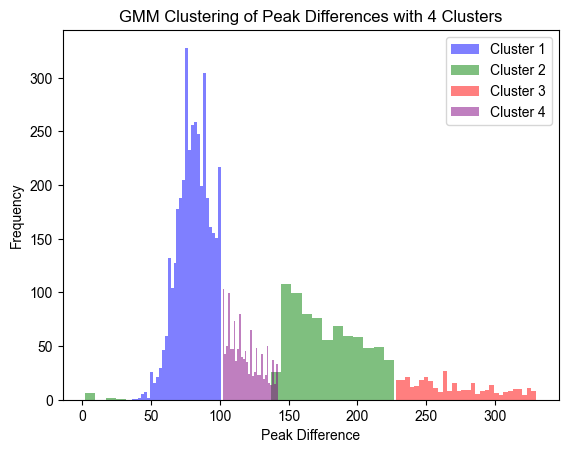

In [198]:
import matplotlib.pyplot as plt

# Histogram Visualization for the GMM Clustering
unique_labels = np.unique(labels)
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Colors for each cluster

for i, label in enumerate(unique_labels):
    plt.hist(data[labels == label], bins=30, alpha=0.5, color=colors[i], label=f'Cluster {label + 1}')

plt.legend()
plt.title(f'GMM Clustering of Peak Differences with {best_n} Clusters')
plt.xlabel('Peak Difference')
plt.ylabel('Frequency')
plt.show()



In [199]:
filtered_df

,peak_index,value,trial_id,name,start,pump_pos,bouts,bout_count,min_pump_pos,peak_diff
1,694,1017.733769,0,Fly05182022_5d,2349,3043,0,6,2883,160.0
2,903,1027.228163,0,Fly05182022_5d,2349,3252,0,6,2883,209.0
3,1207,1021.721591,0,Fly05182022_5d,2349,3556,0,6,2883,304.0
84,1439,916.637105,0,Fly05182022_5d,2349,3788,0,6,2883,232.0
4,1623,1023.545935,0,Fly05182022_5d,2349,3972,0,6,2883,184.0
...,...,...,...,...,...,...,...,...,...,...
8486,835,387.119720,22,Fly08032022_6d_SD_B,625280,626115,31,9,625816,68.0
8487,905,386.726096,22,Fly08032022_6d_SD_B,625280,626185,31,9,625816,70.0
8488,966,389.234434,22,Fly08032022_6d_SD_B,625280,626246,31,9,625816,61.0
8489,1041,504.997931,22,Fly08032022_6d_SD_B,625280,626321,31,9,625816,75.0
